## 1st Iteration

- Run on sample 1000 reviews
- Extract Topics

### Data & Imports

In [2]:
import pandas as pd
import re
import json
import os
import math
from openai import OpenAI
from dotenv import load_dotenv
import time

In [4]:
df = pd.read_csv("Project_Sandals_Google_Reviews_V2.csv")
df['reviews_id'] = df.index + 1
df.dropna(subset='review_text', inplace=True)
df = df.sample(1000)
reviews_df = df[['review_text','reviews_id']]

In [5]:
reviews_df.shape

(1000, 2)

In [6]:
def clean_review(text):
    text = re.sub(r"<.*?>", "", text)
    text = text.replace("\n", " ").strip()
    return text

reviews_df['review_text'] = reviews_df['review_text'].apply(clean_review)

C:\Users\prjain\AppData\Local\Temp\ipykernel_23920\2039213048.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['review_text'] = reviews_df['review_text'].apply(clean_review)


In [7]:
reviews_df['sentiment'] = None
reviews_df['topic'] = None
reviews_df['support_text'] = None
reviews_df['translated_review_text'] = None

C:\Users\prjain\AppData\Local\Temp\ipykernel_23920\2612990079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['sentiment'] = None
C:\Users\prjain\AppData\Local\Temp\ipykernel_23920\2612990079.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['topic'] = None
C:\Users\prjain\AppData\Local\Temp\ipykernel_23920\2612990079.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

### Batch API

#### create batch

In [8]:
MAX_REQUESTS_PER_BATCH = 50000
MAX_BATCH_SIZE_BYTES = 190 * 1024 * 1024  #keeping max size 190mb

def build_request_line(review_id, review_text):

    system_prompt = (
        "You are a helpful assistant that analyzes customer reviews.\n"
        "For each review:\n"
        "- If the review is not in English, translate it to English and include the translated text.\n"
        "  If it is already in English, keep it as is and set translated_text to the original.\n"
        "- Use the English version of the review to identify a short topic label.\n"
        "Return ONLY a strict JSON object with no explanations or extra text, in this exact format:\n"
        '{"translated_text": "...", "topic": "..."}'
    )

    
    request_body = {
        "custom_id": str(review_id),
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": {
            "model": "gpt-4o-mini",
            "messages": [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": f"Review: {review_text}"}
            ],
            #"max_tokens": 1024,         #increased token length as getting None in sentiment, topic & support text
            "temperature": 0.0
        }
    }
    return json.dumps(request_body)


batch_num = 1
batch_lines = []
batch_size_bytes = 0

for idx, row in reviews_df.iterrows():
    line = build_request_line(row['reviews_id'], row['review_text']) + "\n"
    line_size = len(line.encode('utf-8'))

    # Check if adding this line exceeds limits
    if (len(batch_lines) >= MAX_REQUESTS_PER_BATCH) or (batch_size_bytes + line_size > MAX_BATCH_SIZE_BYTES):
        # Write current batch to file
        batch_file = f"batchinput_part{batch_num}.jsonl"
        with open(batch_file, "w", encoding="utf-8") as f:
            f.writelines(batch_lines)
        print(f"Saved batch {batch_num} with {len(batch_lines)} lines ({batch_size_bytes / (1024*1024):.2f} MB) to '{batch_file}'")

        # Reset for next batch
        batch_num += 1
        batch_lines = []
        batch_size_bytes = 0

    # Add current line to batch
    batch_lines.append(line)
    batch_size_bytes += line_size

# Save the last batch if any lines left
if batch_lines:
    batch_file = f"batchinput_part{batch_num}.jsonl"
    with open(batch_file, "w", encoding="utf-8") as f:
        f.writelines(batch_lines)
    print(f"Saved batch {batch_num} with {len(batch_lines)} lines ({batch_size_bytes / (1024*1024):.2f} MB) to '{batch_file}'")

Saved batch 1 with 1000 lines (1.09 MB) to 'batchinput_part1.jsonl'


#### upload batch

In [9]:
[f"batchinput_part{i}.jsonl" for i in range(1, batch_num + 1)]

['batchinput_part1.jsonl']

Uploaded batchinput_part1.jsonl with file id: file-QswCA8xKZGZpwawZAyn3D6
Created batch job for batchinput_part1.jsonl with job id: batch_687907112274819088824ec1f08a2c56


#### download batch output

In [12]:
def poll_and_download(batch_id):
    print(f"Polling batch job {batch_id}...")
    while True:
        batch_info = openai.batches.retrieve(batch_id)
        status = batch_info.status
        print(f"Status of batch {batch_id}: {status}")
        if status in ["completed", "failed", "cancelled", "expired"]:
            break
        time.sleep(10)

    if status != "completed":
        print(f"Batch {batch_id} ended with status {status}. Skipping download.")
        return {}

    output_file_id = batch_info.output_file_id
    print(f"Downloading results for batch {batch_id} with file id {output_file_id}...")

    output_file_response = openai.files.content(output_file_id)
    output_lines = output_file_response.text.splitlines()

    results = {}
    for line in output_lines:
        try:
            result_json = json.loads(line)
            custom_id = result_json.get("custom_id")
            response_body = result_json.get("response", {}).get("body", {})
            choices = response_body.get("choices", [])
            if choices:
                content = choices[0]["message"]["content"]
                try:
                    parsed_content = json.loads(content)
                except json.JSONDecodeError:
                    parsed_content = {
                        "error": "Invalid JSON in GPT response",
                        "raw_content": content
                    }
                results[custom_id] = parsed_content
            else:
                results[custom_id] = {"error": "No choices in response"}
        except Exception as e:
            print(f"Error parsing line in batch {batch_id}: {e}")
    return results


In [13]:
all_results = {}

for job_id in batch_job_ids:
    batch_results = poll_and_download(job_id)
    all_results.update(batch_results)

print(f"Total results fetched: {len(all_results)}")

for col in ['sentiment', 'topic', 'support_text']:
    if col not in reviews_df.columns:
        reviews_df[col] = None

for cid, res in all_results.items():
    if "error" in res:
        continue  # skip errored entries
    
    sentiment = res.get("sentiment")
    topic = res.get("topic")
    support_text = res.get("support_text")
    translated_text = res.get("translated_text")

    mask = reviews_df['reviews_id'].astype(str) == cid
    
    # Update sentiment, topic, support_text
    reviews_df.loc[mask, 'sentiment'] = sentiment
    reviews_df.loc[mask, 'topic'] = topic
    reviews_df.loc[mask, 'support_text'] = support_text

    # Update review_text if translated_text is present and different
    if translated_text and translated_text.strip() and translated_text.strip() != reviews_df.loc[mask, 'review_text'].values[0].strip():
        reviews_df.loc[mask, 'review_text'] = translated_text.strip()

Polling batch job batch_687907112274819088824ec1f08a2c56...
Status of batch batch_687907112274819088824ec1f08a2c56: in_progress
Status of batch batch_687907112274819088824ec1f08a2c56: in_progress
Status of batch batch_687907112274819088824ec1f08a2c56: in_progress
Status of batch batch_687907112274819088824ec1f08a2c56: in_progress
Status of batch batch_687907112274819088824ec1f08a2c56: in_progress
Status of batch batch_687907112274819088824ec1f08a2c56: in_progress
Status of batch batch_687907112274819088824ec1f08a2c56: in_progress
Status of batch batch_687907112274819088824ec1f08a2c56: in_progress
Status of batch batch_687907112274819088824ec1f08a2c56: in_progress
Status of batch batch_687907112274819088824ec1f08a2c56: in_progress
Status of batch batch_687907112274819088824ec1f08a2c56: in_progress
Status of batch batch_687907112274819088824ec1f08a2c56: in_progress
Status of batch batch_687907112274819088824ec1f08a2c56: in_progress
Status of batch batch_687907112274819088824ec1f08a2c56: 

In [14]:
reviews_df

,review_text,reviews_id,sentiment,topic,support_text,translated_review_text
2653,Absolutely love Sandals! This is the second on...,2654,None,Resort Experience,None,None
2800,We are only halfway through our stay and we we...,2801,None,Positive experience at all-inclusive resort,None,None
6032,👍,6033,None,Positive Feedback,None,None
12048,Beautiful resort. Staff were accommodating of ...,12049,None,Resort Experience,None,None
2645,"Awesome couples place, the people here are def...",2646,None,Couples Experience,None,None
...,...,...,...,...,...,...
11362,Good to relax,11363,None,Relaxation,None,None
14345,5 is not a high enough rating. Incredible grou...,14346,None,Exceptional Service and Relaxation,None,None
11870,I stayed two nights in a cabin by the water wi...,11871,None,Beautiful location and good food,None,None
1540,The facility is amazing! The grounds are lovel...,1541,None,Food Poisoning and Service Issues,None,None


#### extract topics

In [15]:
input_topics = reviews_df['topic'].dropna().unique().tolist()
print(input_topics)

['Resort Experience', 'Positive experience at all-inclusive resort', 'Positive Feedback', 'Couples Experience', 'Exceptional Service', 'Clean room and delicious food', 'Honeymoon Experience at Sandals', 'Customer Service Issues', 'Hotel experience', 'Room Quality and Location', 'Staff and Accommodations', 'Food and Service', 'Positive vacation experience', 'Hotel Experience', 'Service Quality', 'Positive Experience', 'Positive feedback', 'Poor cleanliness and customer service at resort', 'Excellent hotel experience', 'Cultural Suitability', 'Customer Service', 'Pricing and Aesthetics', 'Vacation Experience', 'Spectacular experience', 'Excellent dining experience', 'Positive hotel experience', 'Relaxation', 'Honeymoon Experience', 'Bartender Experience', 'Accommodation', 'Anniversary Celebration and Excellent Service', 'Accommodation and Amenities', 'Relaxation and Activities', 'New resort experience and service issues', 'Island Experience', 'Overall experience and service quality', 'We

In [ ]:
##chatgpt prompt to create a concise list using above list from : reviews_df['topic'].dropna().unique().tolist()

# You are a data analyst assisting with text clustering.

# Given a list of specific review topic phrases, your task is to:
# 1. Identify common semantic themes shared across the list.
# 2. Merge overlapping topics and group them under broader, high-level categories.
# 3. Return a concise list of unique, generalized topic labels (each 1–3 words long). 
# 4. Avoid repeating similar concepts with different wording — generalize wherever possible.
# 5. Output only a clean Python list of the merged topics.

# Input:
# <input list>

# Return:
# A Python list named `broader_topics` containing the merged, high-level categories. broader_topics list should not be more then 15-20 topics, merge similar aspects wherever possible

## Note

1. Process sample of 1000 reviews and extract topics
2. Extract Broader Topics (High-Level Groups) from the list of extracted topics and calling them "Topic_Category"
3. Process whole dataset and Extract Topics normally without influencing and calling them "Topic"
4. Map Topic to Topic_Category, So finally we will have 2 columns:
    + Topic (which is topic based on review_text)
    + Topic_Category (which category that topic falls in..)

In [23]:
broader_topics = [
    "Accommodation Experience",
    "Service and Hospitality",
    "Food and Dining",
    "Atmosphere and Relaxation",
    "Special Occasions and Events",
    "Entertainment and Activities",
    "Location and Accessibility",
    "Pricing and Value"
]

broader_topics.append('Others')

## 2nd Iteration

- Process full dataset on broader_topics
- Extract Sentiment Score, Topic, Topic_Category, Support Text, Translated text etc

### Data & Imports

In [25]:
df = pd.read_csv("Project_Sandals_Google_Reviews_V2.csv")
df['reviews_id'] = df.index + 1
df.dropna(subset='review_text', inplace=True)
df = df.sample(5000)
reviews_df = df[['review_text','reviews_id']]

def clean_review(text):
    text = re.sub(r"<.*?>", "", text)
    text = text.replace("\n", " ").strip()
    return text

reviews_df['review_text'] = reviews_df['review_text'].apply(clean_review)

reviews_df['sentiment'] = None
reviews_df['topic'] = None
reviews_df['support_text'] = None
reviews_df['translated_review_text'] = None

C:\Users\prjain\AppData\Local\Temp\ipykernel_23920\1361163969.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['review_text'] = reviews_df['review_text'].apply(clean_review)
C:\Users\prjain\AppData\Local\Temp\ipykernel_23920\1361163969.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['sentiment'] = None
C:\Users\prjain\AppData\Local\Temp\ipykernel_23920\1361163969.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

### Batch API

#### create batch

In [28]:
MAX_REQUESTS_PER_BATCH = 50000
MAX_BATCH_SIZE_BYTES = 190 * 1024 * 1024  #keeping max size 190mb

def build_request_line(review_id, review_text):

    system_prompt = (
    "You are a helpful assistant that analyzes customer reviews.\n"
    "For each review:\n"
    "- If the review is not in English, translate it to English first and include the translated text.\n"
    "  If it's already in English, keep it as is and set translated_text to the original.\n"
    "- Use the English version of the review to:\n"
    "  - Determine the sentiment score as a number between -1.0 (very negative) and 1.0 (very positive).\n"
    "    - Use negative numbers for negative sentiment, positive numbers for positive sentiment.\n"
    "    - Use 0.0 for neutral or balanced reviews.\n"
    "    - Use the English version of the review to identify a short topic label.\n"
    "  - Extract a short **exact phrase** (verbatim) from the English text that supports the topic.\n\n"
    "Return ONLY a strict JSON object with the following format (no explanations, no extra text):\n"
    '{"translated_text": "...", "sentiment": ..., "topic": "...", "support_text": "..."}'
    )

    
    request_body = {
        "custom_id": str(review_id),
        "method": "POST",
        "url": "/v1/chat/completions",
        "body": {
            "model": "gpt-4o-mini",
            "messages": [
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": f"Review: {review_text}"}
            ],
            #"max_tokens": 1024,         #increased token length as getting None in sentiment, topic & support text
            "temperature": 0.0
        }
    }
    return json.dumps(request_body)


batch_num = 1
batch_lines = []
batch_size_bytes = 0

for idx, row in reviews_df.iterrows():
    line = build_request_line(row['reviews_id'], row['review_text']) + "\n"
    line_size = len(line.encode('utf-8'))

    # Check if adding this line exceeds limits
    if (len(batch_lines) >= MAX_REQUESTS_PER_BATCH) or (batch_size_bytes + line_size > MAX_BATCH_SIZE_BYTES):
        # Write current batch to file
        batch_file = f"batchinput_part{batch_num}.jsonl"
        with open(batch_file, "w", encoding="utf-8") as f:
            f.writelines(batch_lines)
        print(f"Saved batch {batch_num} with {len(batch_lines)} lines ({batch_size_bytes / (1024*1024):.2f} MB) to '{batch_file}'")

        # Reset for next batch
        batch_num += 1
        batch_lines = []
        batch_size_bytes = 0

    # Add current line to batch
    batch_lines.append(line)
    batch_size_bytes += line_size

# Save the last batch if any lines left
if batch_lines:
    batch_file = f"batchinput_part{batch_num}.jsonl"
    with open(batch_file, "w", encoding="utf-8") as f:
        f.writelines(batch_lines)
    print(f"Saved batch {batch_num} with {len(batch_lines)} lines ({batch_size_bytes / (1024*1024):.2f} MB) to '{batch_file}'")

Saved batch 1 with 5000 lines (7.67 MB) to 'batchinput_part1.jsonl'


#### upload batch

In [29]:
[f"batchinput_part{i}.jsonl" for i in range(1, batch_num + 1)]

['batchinput_part1.jsonl']

In [30]:
load_dotenv()
openai = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

batch_job_ids = []

# Assume batch_num is the number of batches you created before
batch_files = [f"batchinput_part{i}.jsonl" for i in range(1, batch_num + 1)]

for bf in batch_files:
    # Upload the batch file
    with open(bf, "rb") as f:
        upload_response = openai.files.create(
            file=f,
            purpose="batch",
        )
    input_file_id = upload_response.id
    print(f"Uploaded {bf} with file id: {input_file_id}")

    # Create a batch job for this uploaded file
    batch_response = openai.batches.create(
    input_file_id=input_file_id,
    endpoint="/v1/chat/completions",
    completion_window="24h",
    )

    print(f"Created batch job for {bf} with job id: {batch_response.id}")
    batch_job_ids.append(batch_response.id)

Uploaded batchinput_part1.jsonl with file id: file-4eMt5NevbgfgYSNMWKBR9s
Created batch job for batchinput_part1.jsonl with job id: batch_687924fc2dc0819099595937c0b48bb5


#### download batch output

In [31]:
def poll_and_download(batch_id):
    print(f"Polling batch job {batch_id}...")
    while True:
        batch_info = openai.batches.retrieve(batch_id)
        status = batch_info.status
        print(f"Status of batch {batch_id}: {status}")
        if status in ["completed", "failed", "cancelled", "expired"]:
            break
        time.sleep(10)

    if status != "completed":
        print(f"Batch {batch_id} ended with status {status}. Skipping download.")
        return {}

    output_file_id = batch_info.output_file_id
    print(f"Downloading results for batch {batch_id} with file id {output_file_id}...")

    output_file_response = openai.files.content(output_file_id)
    output_lines = output_file_response.text.splitlines()

    results = {}
    for line in output_lines:
        try:
            result_json = json.loads(line)
            custom_id = result_json.get("custom_id")
            response_body = result_json.get("response", {}).get("body", {})
            choices = response_body.get("choices", [])
            if choices:
                content = choices[0]["message"]["content"]
                try:
                    parsed_content = json.loads(content)
                except json.JSONDecodeError:
                    parsed_content = {
                        "error": "Invalid JSON in GPT response",
                        "raw_content": content
                    }
                results[custom_id] = parsed_content
            else:
                results[custom_id] = {"error": "No choices in response"}
        except Exception as e:
            print(f"Error parsing line in batch {batch_id}: {e}")
    return results


In [32]:
all_results = {}

for job_id in batch_job_ids:
    batch_results = poll_and_download(job_id)
    all_results.update(batch_results)

print(f"Total results fetched: {len(all_results)}")

for col in ['sentiment', 'topic', 'support_text']:
    if col not in reviews_df.columns:
        reviews_df[col] = None

for cid, res in all_results.items():
    if "error" in res:
        continue  # skip errored entries
    
    sentiment = res.get("sentiment")
    topic = res.get("topic")
    support_text = res.get("support_text")
    translated_text = res.get("translated_text")

    mask = reviews_df['reviews_id'].astype(str) == cid
    
    # Update sentiment, topic, support_text
    reviews_df.loc[mask, 'sentiment'] = sentiment
    reviews_df.loc[mask, 'topic'] = topic
    reviews_df.loc[mask, 'support_text'] = support_text

    # Update review_text if translated_text is present and different
    if translated_text and translated_text.strip() and translated_text.strip() != reviews_df.loc[mask, 'review_text'].values[0].strip():
        reviews_df.loc[mask, 'review_text'] = translated_text.strip()

Polling batch job batch_687924fc2dc0819099595937c0b48bb5...
Status of batch batch_687924fc2dc0819099595937c0b48bb5: in_progress
Status of batch batch_687924fc2dc0819099595937c0b48bb5: in_progress
Status of batch batch_687924fc2dc0819099595937c0b48bb5: in_progress
Status of batch batch_687924fc2dc0819099595937c0b48bb5: in_progress
Status of batch batch_687924fc2dc0819099595937c0b48bb5: in_progress
Status of batch batch_687924fc2dc0819099595937c0b48bb5: in_progress
Status of batch batch_687924fc2dc0819099595937c0b48bb5: in_progress
Status of batch batch_687924fc2dc0819099595937c0b48bb5: in_progress
Status of batch batch_687924fc2dc0819099595937c0b48bb5: in_progress
Status of batch batch_687924fc2dc0819099595937c0b48bb5: in_progress
Status of batch batch_687924fc2dc0819099595937c0b48bb5: in_progress
Status of batch batch_687924fc2dc0819099595937c0b48bb5: in_progress
Status of batch batch_687924fc2dc0819099595937c0b48bb5: in_progress
Status of batch batch_687924fc2dc0819099595937c0b48bb5: 

In [33]:
reviews_df

,review_text,reviews_id,sentiment,topic,support_text,translated_review_text
2235,I was a returning customer to Sandals and had ...,2236,-1.0,Customer Service Issues,The customer service was downright rude and sa...,None
636,This was our first Sandals experience and I mu...,637,0.9,Positive experience at Sandals,Everything from the grounds to the room to the...,None
11561,Great choice for a honeymoon. No complaints. R...,11562,0.9,honeymoon experience,Great choice for a honeymoon.,None
1317,Easy Breezy consistently goes above and beyond...,1318,1.0,Exceptional Service,goes above and beyond in providing exceptional...,None
9972,"We were four (2 adults, 2 teenagers) for 10 da...",9973,0.9,Positive vacation experience,"We had a very relaxing vacation, ate excellently",None
...,...,...,...,...,...,...
6471,"It was regular since the room had no windows, ...",6472,-0.5,Room discomfort,making it uncomfortable to sleep,None
351,If you want to be spoiled...this is the Resort...,352,1.0,Positive experience at the resort,I would highly recommend this Resort that give...,None
13693,Wonderful atmosphere and the workers were extr...,13694,1.0,Positive experience,Customer service beyond expectations,None
5013,Guest friendly and very centrally located. Sur...,5014,0.9,Location and amenities,very centrally located,None


In [35]:
len(reviews_df['topic'].dropna().unique().tolist())

1589

In [41]:
broader_topics

['Accommodation Experience',
 'Service and Hospitality',
 'Food and Dining',
 'Atmosphere and Relaxation',
 'Special Occasions and Events',
 'Entertainment and Activities',
 'Location and Accessibility',
 'Pricing and Value',
 'Others']

### Map Topic to Topic_Category 

#### Single Run

In [40]:
# from tqdm import tqdm

# broader_topics = [
#     "Accommodation Experience",
#     "Service and Hospitality",
#     "Food and Dining",
#     "Atmosphere and Relaxation",
#     "Special Occasions and Events",
#     "Entertainment and Activities",
#     "Location and Accessibility",
#     "Pricing and Value",
#     "Others"
# ]


# def categorize_topic(topic, broader_topics):
#     prompt = f"""
#         You are given a list of broader topics:

#         {', '.join(broader_topics)}

#         Please categorize the following topic into ONE of the broader topics above. 
#         If none fit well, respond with "Others".

#         Topic: "{topic}"
#         Category:
#         """

#     try:
#         response = openai.ChatCompletion.create(
#             model="gpt-4o-mini",
#             messages=[{"role": "user", "content": prompt}],
#             temperature=0)
        
#         category = response['choices'][0]['message']['content'].strip()
        
#         if category not in broader_topics:
#             category = "Others"
        
#         return category
#     except Exception as e:
#         print(f"Error categorizing topic '{topic}': {e}")
#         return "Others"



# unique_topics = reviews_df['topic'].dropna().unique()

# # Map topics to categories using GPT-4o-mini
# topic_to_category = {}
# for t in tqdm(unique_topics, desc="Categorizing topics"):
#     topic_to_category[t] = categorize_topic(t, broader_topics)


# reviews_df['topic_category'] = reviews_df['topic'].map(topic_to_category).fillna('Others')

#### batch run

In [53]:
import os
from dotenv import load_dotenv
from openai import OpenAI
from tqdm import tqdm
import pandas as pd

# Load your OpenAI API key from .env file or environment variables
load_dotenv()
openai = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Batch size for API calls
BATCH_SIZE = 50

def batch_categorize(topics, broader_topics):
    prompt = f"""
You are a helpful assistant. Given the following broader topics:

{', '.join(broader_topics)}

Classify each of the following input topics into ONE of the broader topics. 
Respond with a list in the same order, where each line shows the topic followed by a colon and the selected category.
If none fit, use "Others".

Topics:
"""
    for topic in topics:
        prompt += f"- {topic}\n"

    try:
        response = openai.chat.completions.create(
            model="gpt-4o-mini",
            messages=[{"role": "user", "content": prompt}],
            temperature=0
        )
        content = response.choices[0].message.content

        result = {}
        for line in content.strip().splitlines():
            if ':' in line:
                topic, category = line.split(':', 1)
                topic = topic.strip("- ").strip()
                category = category.strip()
                if category not in broader_topics:
                    category = "Others"
                result[topic] = category
        return result

    except Exception as e:
        print(f"Batch failed: {e}")
        # Fallback: assign "Others" to all topics in the batch
        return {topic: "Others" for topic in topics}

# Assuming you already have a DataFrame `reviews_df` with a 'topic' column
# Extract unique topics (non-null)
unique_topics = reviews_df['topic'].dropna().unique().tolist()

# Dictionary to store mapping topic -> category
topic_to_category = {}

# Process topics in batches with progress bar
for i in tqdm(range(0, len(unique_topics), BATCH_SIZE), desc="Batch categorizing topics"):
    batch = unique_topics[i:i + BATCH_SIZE]
    batch_result = batch_categorize(batch, broader_topics)
    topic_to_category.update(batch_result)

# Map the categories back to the DataFrame safely (avoid SettingWithCopyWarning)
reviews_df.loc[:, 'topic_category'] = reviews_df['topic'].map(topic_to_category).fillna('Others')


Batch categorizing topics: 100%|██████████| 32/32 [04:34<00:00,  8.59s/it]
C:\Users\prjain\AppData\Local\Temp\ipykernel_23920\3063220599.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df.loc[:, 'topic_category'] = reviews_df['topic'].map(topic_to_category).fillna('Others')


## Results

In [57]:
reviews_df['topic_category'].value_counts()

topic_category
Accommodation Experience        2062
Service and Hospitality          943
Others                           923
Food and Dining                  261
Atmosphere and Relaxation        233
Special Occasions and Events     229
Location and Accessibility       185
Entertainment and Activities     112
Pricing and Value                 52
Name: count, dtype: int64

In [61]:
reviews_df['topic'].value_counts()

topic
Positive experience                     925
Positive experience at the resort       128
Positive experience at resort            85
positive experience                      80
Overall experience                       68
                                       ... 
Friendly locals                           1
appreciation of life                      1
Air conditioning                          1
Recommendation for all ages               1
Overall experience and staff service      1
Name: count, Length: 1589, dtype: int64

C:\Users\prjain\AppData\Local\Temp\ipykernel_23920\3077945515.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_df['sentiment_label'] = reviews_df['sentiment'].astype(float).apply(categorize_sentiment)


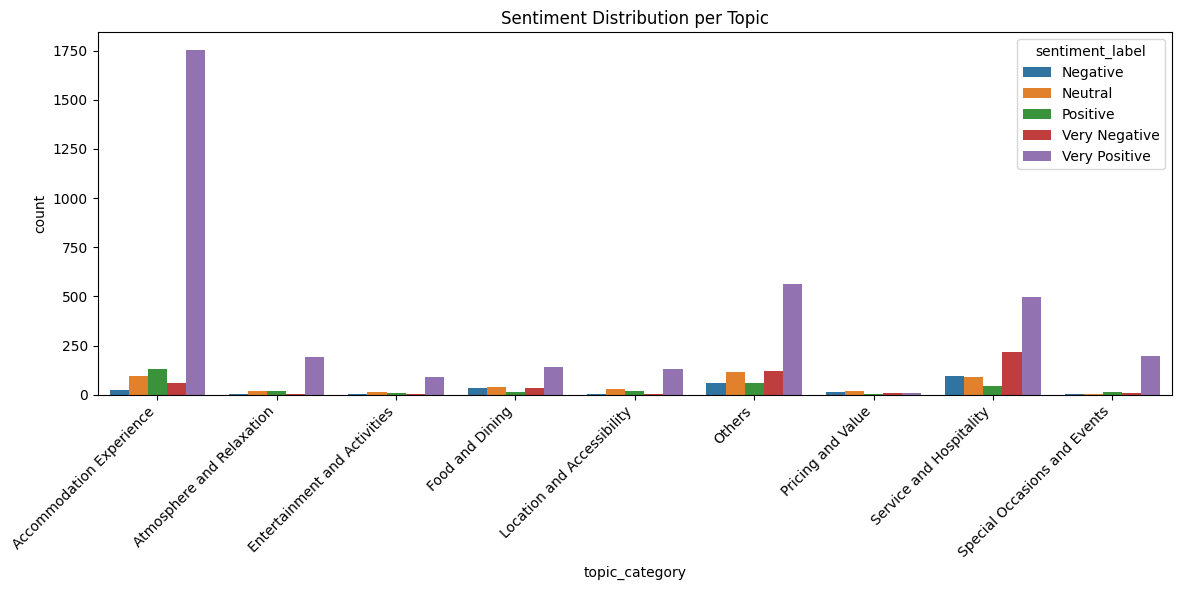

In [60]:
def categorize_sentiment(score):
    if score >= 0.7:
        return "Very Positive"
    elif score >= 0.4:
        return "Positive"
    elif score > -0.4 and score < 0.4:
        return "Neutral"
    elif score <= -0.7:
        return "Very Negative"
    else:  # score between -0.7 and -0.4
        return "Negative"

reviews_df['sentiment_label'] = reviews_df['sentiment'].astype(float).apply(categorize_sentiment)

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sentiment_counts = reviews_df.groupby(['topic_category', 'sentiment_label']).size().reset_index(name='count')
sns.barplot(data=sentiment_counts, x='topic_category', y='count', hue='sentiment_label')
plt.xticks(rotation=45, ha='right')
plt.title("Sentiment Distribution per Topic")
plt.tight_layout()
plt.show()


In [62]:
jakub_df = pd.read_csv(r"C:\Users\prjain\Downloads\0702_sandals_deep_dive_combined_ReviewDateFix.csv")

C:\Users\prjain\AppData\Local\Temp\ipykernel_23920\2435727091.py:1: DtypeWarning: Columns (10,11,17,22) have mixed types. Specify dtype option on import or set low_memory=False.
  jakub_df = pd.read_csv(r"C:\Users\prjain\Downloads\0702_sandals_deep_dive_combined_ReviewDateFix.csv")


In [64]:
jakub_df['aspect_category'].value_counts()

aspect_category
Service & Hospitality    1472684
Dining & Drinks          1236931
General                   907314
Rooms & Suites            645392
Name: count, dtype: int64

In [70]:
reviews_df['topic_category'].value_counts()

topic_category
Accommodation Experience        2062
Service and Hospitality          943
Others                           923
Food and Dining                  261
Atmosphere and Relaxation        233
Special Occasions and Events     229
Location and Accessibility       185
Entertainment and Activities     112
Pricing and Value                 52
Name: count, dtype: int64